## 1. Introduction 

### 1.1 Motivation 

In this notebook, I retrieve the second-month quarterly futures prices from the OWF (OurWorld Financial) database for the pairs ICE_B_B vs. ICE_G_G and NYM_RB_RB vs. ICE_G_G, spanning from December 3, 2020, to August 31, 2023. The notebook is structured into three sections.

In the first section, I introduce and cover all the necessary Python packages, constants, and functions that will be utilized throughout the analysis.

The second section focuses on data extraction and cleaning. Here, I extract and preprocess the data for these three futures pairs, ensuring it is ready for further analysis.

In section three, I delve into exploratory data analysis for the selected pairs. This involves conducting basic summary statistics and creating data visualizations to unveil fundamental characteristics and trends in the spreads. Additionally, I plan to perform time series and comparative analyses to assess the dynamic behavior and relationships between these two pairs.

Data source: Quandl OWF database 

Selected Pairs: ICE_B_B versus ICE_G_G (1) and NYM_RB_RB versus ICE_G_G (8)

ICE_B_B: Brent Crude Oil 

ICE_G_G: ICE Gas Oil

NYM_RB_RB: Gasoline 

### 1.2 Packages & Key Constants & Helper Functions

#### Packages 

In [1]:
%matplotlib inline

In [201]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm
import plotly.express as px
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import coint


#### Key Constants 

In [31]:
myAPIkey = 'yourAPI'

start_date = '2020-12-03'
end_date = '2023-08-31'

#futures = [{'ICE_B_B': 1.0}, {'ICE_G_G': 0.1147}, {'NYM_RB_RB': 1.0},{'ICE_G_G': 0.0033}]
futures_names = ['ICE_B_B','ICE_G_G','NYM_RB_RB','ICE_G_G']
futures_multiplier = [1.0, 0.1147, 1.0, 0.0033]

year = ['2021','2022','2023']
quarter = ['H','M','U','Z']

check_data_match_pair_ICEBB_ICEGG = {'2021-09-28': -2.676675, '2021-09-29': 0.038750, '2021-11-10': -0.077950}
check_data_match_pair_NYMRBRB_ICEGG = {'2021-10-29': -0.019275, '2021-11-01': 0.048500, '2021-11-10': 0.0063650}

#### Helper Functions 

##### fetching data 

In [4]:
def get_data(name, start_date, end_date): 
    # create an empty list to store dataframe 
    data_list = list() 

    #get all the data that expires in the month we want 
    for y in year: 
        for q in quarter: 
            df = quandl.get('OWF/' + name + '_' + q + y + '_IVM', returns = 'pandas', start_date = start_date, end_date = end_date, api_key = myAPIkey)
            df = df[['Future','DtT']]
            df.rename(columns={'Future': 'FuturePrice', 'DtT':'DtT(expiration)'}, inplace=True)
            df['FuturePrice'] = np.where((df['DtT(expiration)'] > 30),df['FuturePrice'],0.0)
            df = df[df['FuturePrice'] != 0.0]
            df['Expiration'] = q+y 
            df['FutureName'] = name 
            data_list.append(df)

    #get the lowest timeto expiration 
    data = pd.concat(data_list)
    min_DtT = data.groupby(data.index)['DtT(expiration)'].transform('min')
    data_filtered = data[data['DtT(expiration)'] == min_DtT].reset_index()
    data_filtered = data_filtered.set_index('Date')
    return data_filtered 

##### checking data 

In [29]:
def check_data(df, correct_data): 
    match = False 
    for k,v in correct_data.items(): 
        if round(df.loc[k],6) == correct_data[k]:
            match = True 
    if match: 
        print('You get the correct datapoints.')
    else: 
        print('Something is wrong.')

##### summary statistics  

In [69]:
def summary_statistics(data):
    summary_stats = pd.DataFrame()
    summary_stats['Mean'] = round(data.mean(),3)
    summary_stats['Standard deviation'] = round(data.std(),3)
    
    summary_stats['VaR (0.05)'] = round(data.quantile(0.05),3)
    summary_stats['Quantile 0.25'] = round(data.quantile(0.25),3)
    summary_stats['Median'] = round(data.median(),3)
    summary_stats['Quantile 0.75'] = round(data.quantile(0.75),3)
    
    summary_stats['Skewness'] = round(data.skew(),3)
    summary_stats['Excess Kurtosis'] = round(data.kurtosis(),3)

    summary_stats['Min'] = round(data.min(),3)
    summary_stats['Max'] = round(data.max(),3)
    return summary_stats

##### N-day rolling average 

In [157]:
def rolling_diff_average(df, N):
    rolling_df = df['FuturePrice'].rolling(N).mean().to_frame().rename(columns={'FuturePrice': 'Rolling_Avg_'+str(N)})
    return rolling_df 

## 2. Data 

### 2.1 Data fecthing from Quandl

Here, I plan to utilize the helper function wrote before to get the data. The key idea is to get all the futures contract that expires in the month and year range provided before. Then, choosing the futures contract which have DtT longer than 30 days. After that, finding the shortest DtT in each unique date. Here, we utilize this function to get the data for all three types of futures contract. We checked its shape in order to do further operation. 

In [15]:
ICE_B_B = get_data(futures_names[0],start_date, end_date)
ICE_G_G = get_data(futures_names[1],start_date, end_date)
NYM_RB_RB = get_data(futures_names[2],start_date, end_date)

print('Display of ICE_B_B: ')
display(ICE_B_B.head(2))
print(ICE_B_B.shape) 

print('Display of ICE_G_G: ')
display(ICE_G_G.head(2))
print(ICE_G_G.shape) 

print('Display of NYM_RB_RB: ')
display(NYM_RB_RB.head(2))
print(NYM_RB_RB.shape) 

Display of ICE_B_B: 


,FuturePrice,DtT(expiration),Expiration,FutureName
Date,,,,
2020-12-03,48.60,57.0,H2021,ICE_B_B
2020-12-04,49.19,56.0,H2021,ICE_B_B


(709, 4)
Display of ICE_G_G: 


,FuturePrice,DtT(expiration),Expiration,FutureName
Date,,,,
2020-12-03,404.75,98.0,H2021,ICE_G_G
2020-12-04,406.00,97.0,H2021,ICE_G_G


(709, 4)
Display of NYM_RB_RB: 


,FuturePrice,DtT(expiration),Expiration,FutureName
Date,,,,
2020-12-03,1.2867,85.0,H2021,NYM_RB_RB
2020-12-04,1.2951,84.0,H2021,NYM_RB_RB


(715, 4)


In [8]:
ICE_G_G_Adjusted_1 = ICE_G_G.copy() 
ICE_G_G_Adjusted_1['FuturePrice'] = ICE_G_G_Adjusted_1['FuturePrice'] * futures_multiplier[1]

ICE_G_G_Adjusted_2 = ICE_G_G.copy() 
ICE_G_G_Adjusted_2['FuturePrice'] = ICE_G_G_Adjusted_2['FuturePrice'] * futures_multiplier[3]

display(ICE_G_G_Adjusted_1.head(2))
display(ICE_G_G_Adjusted_2.head(2))

,FuturePrice,DtT(expiration),Expiration,FutureName
Date,,,,
2020-12-03,46.424825,98.0,H2021,ICE_G_G
2020-12-04,46.568200,97.0,H2021,ICE_G_G


,FuturePrice,DtT(expiration),Expiration,FutureName
Date,,,,
2020-12-03,1.335675,98.0,H2021,ICE_G_G
2020-12-04,1.339800,97.0,H2021,ICE_G_G


In [53]:
Three_Futures_Summary = pd.DataFrame() 
Three_Futures_Summary['ICE_B_B'] = ICE_B_B['FuturePrice']
Three_Futures_Summary['ICE_G_G'] = ICE_G_G['FuturePrice']
Three_Futures_Summary['NYM_RB_RB'] = NYM_RB_RB['FuturePrice']

display(Three_Futures_Summary.head(2))

,ICE_B_B,ICE_G_G,NYM_RB_RB
Date,,,
2020-12-03,48.60,404.75,1.2867
2020-12-04,49.19,406.00,1.2951


### 2.2 Creating Dataframes 

After getting all the data for 3 futures, we use the data obtained to calcualted the value for spreads. Here, we do not do much for data cleaning since only one dataframe has different size than others. We checked the index between two pairs and then dropped the values that do not align with index. Then we utilize the corret data provided in the problem set to check whether we get correct datapoints. 

In [226]:
pair1 = ICE_G_G_Adjusted_1['FuturePrice'] - ICE_B_B['FuturePrice'] 
pair2 = ICE_G_G_Adjusted_2['FuturePrice'] - NYM_RB_RB['FuturePrice']
pair1 = pair1.dropna()
pair2 = pair2.dropna() 

#check the index 
if pair1.index.equals(pair2.index):
    print("DataFrames have the same index.")
else:
    print("DataFrames do not have the same index.")

#check the size 
print('Pair 1 Shape: ', pair1.shape)
print('Pair 1 Shape: ', pair2.shape)

DataFrames have the same index.
Pair 1 Shape:  (709,)
Pair 1 Shape:  (709,)


In [13]:
data_pairs = pd.DataFrame({'ICE_B_B vs ICE_G_G': pair1, 'NYM_RB_RB vs ICE_G_G': pair2})
display(data_pairs.head(2))

,ICE_B_B vs ICE_G_G,NYM_RB_RB vs ICE_G_G
Date,,
2020-12-03,-2.175175,0.048975
2020-12-04,-2.621800,0.044700


In [248]:
#pair1 = pair1.to_frame()
pair1.index = ICE_G_G_Adjusted_1.index 
#pair2 = pair2.to_frame()
pair2.index = ICE_G_G_Adjusted_1.index 

pandas.core.frame.DataFrame

In [32]:
check_data(data_pairs.loc[:,'ICE_B_B vs ICE_G_G'], check_data_match_pair_ICEBB_ICEGG)
check_data(data_pairs.loc[:,'NYM_RB_RB vs ICE_G_G'],check_data_match_pair_NYMRBRB_ICEGG)

You get the correct datapoints.
You get the correct datapoints.


## 3.Analysis 

To analyze the spread indvidually and combinly, I did following analysis: 

3.1 Descriptive Analysis (Summary staitistics for individual spread):
* mean, median, min, max 
* standard devidation, VaR  
* skewness, excess kurtosis 

3.2 Visual Analysis (for individual spread):
* line chart/ spread chart 
* histogram 
* box plot
* scatter plot (study relationship between two spreads)

3.3 Time series Analysis (for individual spread): 
* rolling mean 
* stationarity check 
* autocorrelation check 

3.4 Comparative Analysis (comparative study for two spreads together):
* correlation 
* dynamic corrlation 
* cointegration test 
* difference between two spreads 

SideNote: In this notebook I did not put the scaling in front of ICE_G_G, but all the data are sacled for further analysis. Also, first pair indicates ICE_B_B vs ICE_G_G and second pair indicates NYM_RB_RB vs ICE_G_G in the analysis. 

### 3.1 Descriptive Analysis

Summary statistics offer a comprehensive view of three futures and two pairs of spreads. When examining ICE_B_B vs. ICE_G_G and NYM_RB_RB vs. ICE_G_G, noteworthy insights emerge. Both pairs exhibit a positive mean, signifying that, on average, the price of ICE_G_G (scaled) surpasses that of ICE_B_B and NYM_RB_RB. However, the second pair's median lies below zero, suggesting a prevalence of data points below zero. Furthermore, both pairs demonstrate relatively high standard deviations, indicating heightened volatility in their price differences. This is further substantiated by observing the Min-Max ranges. Positive skewness in both spreads implies a rightward skew, indicating a leaning toward higher values. Conversely, negative excess kurtosis implies thinner tails and a flatter distribution, comapred with normal distributions.

In [70]:
SummaryStatistics_pair = summary_statistics(data_pairs)
SummaryStatistics_each = summary_statistics(Three_Futures_Summary)
display(SummaryStatistics_pair)
display(SummaryStatistics_each)


,Mean,Standard deviation,VaR (0.05),Quantile 0.25,Median,Quantile 0.75,Skewness,Excess Kurtosis,Min,Max
ICE_B_B vs ICE_G_G,6.852,10.612,-4.423,-2.614,3.168,16.096,0.715,-0.754,-6.509,32.981
NYM_RB_RB vs ICE_G_G,0.105,0.343,-0.266,-0.150,-0.009,0.333,1.009,-0.055,-0.364,1.053


,Mean,Standard deviation,VaR (0.05),Quantile 0.25,Median,Quantile 0.75,Skewness,Excess Kurtosis,Min,Max
ICE_B_B,81.142,14.693,55.554,71.93,80.420,89.13,0.324,0.105,48.600,123.480
ICE_G_G,767.163,201.670,459.700,600.75,738.250,923.25,0.307,-0.789,404.750,1250.000
NYM_RB_RB,2.426,0.494,1.565,2.11,2.381,2.61,0.528,0.589,1.285,3.892


### 3.2 Visual Analysis

#### line charts 

These charts provide a visual representation of the price difference over time. They serve as a window into potential trends, cycles, and patterns that may be present in the data. Notable fluctuations in these charts can often be linked to specific market events or shifts in the supply and demand dynamics of the underlying commodities.

The observed trends in these price spreads align with the individual futures' line charts. Returning to the spread charts, a distinct upward trend is evident from February 2022 through the end of 2022. This period may be correlated with the Russia-Ukraine conflict, which could have stimulated fluctuations in oil prices.

Beginning in 2023, there is a gradual decline in prices, followed by an upward trend starting in August 2023. This latter trend could potentially be attributed to a market tightening, a scenario projected by the International Energy Agency report

In [87]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('ICE_B_B vs ICE_G_G Line Chart', 'NYM_RB_RB vs ICE_G_G Line Chart'))
fig.add_trace(
    go.Scatter(x=data_pairs.index, y=data_pairs['ICE_B_B vs ICE_G_G'], mode='lines', name='ICE_B_B vs ICE_G_G'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=data_pairs.index, y=data_pairs['NYM_RB_RB vs ICE_G_G'], mode='lines', name='NYM_RB_RB vs ICE_G_G'),
    row=1, col=2
)
fig.update_xaxes(title_text="date", row=1, col=1)
fig.update_yaxes(title_text="price difference", row=1, col=1)

fig.update_xaxes(title_text="date", row=1, col=2)
fig.update_yaxes(title_text="price difference", row=1, col=2)
fig.show()

In [88]:
fig = make_subplots(rows=1, cols=3, subplot_titles=('ICE_B_B Line Chart', 'ICE_G_G Line Chart', 'NYM_RB_RB Line Chart'))
fig.add_trace(
    go.Scatter(x=Three_Futures_Summary.index, y=Three_Futures_Summary['ICE_B_B'], mode='lines', name='ICE_B_B Line Chart'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=Three_Futures_Summary.index, y=Three_Futures_Summary['ICE_G_G'], mode='lines', name='ICE_G_G Line Chart'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=Three_Futures_Summary.index, y=Three_Futures_Summary['NYM_RB_RB'], mode='lines', name='NYM_RB_RB Line Chart'),
    row=1, col=3
)
fig.update_xaxes(title_text="date", row=1, col=1)
fig.update_yaxes(title_text="futures price", row=1, col=1)
fig.update_xaxes(title_text="date", row=1, col=2)
fig.update_yaxes(title_text="futures price", row=1, col=2)
fig.update_xaxes(title_text="date", row=1, col=3)
fig.update_yaxes(title_text="futures price", row=1, col=3)
fig.show()

#### Histograms 

These histograms give us a visual impression for the summary statistics described in the previous part. The 'ICE_B_B vs ICE_G_G' data set has a wider range and a right-skewed distribution, whereas the 'NYM_RB_RB vs ICE_G_G' data set is more concentrated around its central value and has a more symmetric distribution. The 'ICE_B_B vs ICE_G_G' data set may have outliers or extreme values causing the long right tail, which could be of interest for further analysis, such as investigating the causes of these extreme values.

In [263]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('ICE_B_B vs ICE_G_G Histogram', 'NYM_RB_RB vs ICE_G_G Histogram'))
fig.add_trace(go.Histogram(x=data_pairs['ICE_B_B vs ICE_G_G'], nbinsx=100, name='ICE_B_B vs ICE_G_G'),
              row=1, col=1)
fig.add_trace(go.Histogram(x=data_pairs['NYM_RB_RB vs ICE_G_G'], nbinsx=100, name='NYM_RB_RB vs ICE_G_G'),
              row=1, col=2)
fig.update_xaxes(title_text='Future Price', row=1, col=1)
fig.update_xaxes(title_text='Future Price', row=1, col=2)
fig.update_yaxes(title_text='Frequency', row=1, col=1)
fig.update_yaxes(title_text='Frequency', row=1, col=2)
fig.show()

#### Boxplots 

These provide a visual summary of the distribution's central tendency and variability, and help identify outliers. They aligns with statistical summary and histograms obtained above.

In [237]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('ICE_B_B vs ICE_G_G Boxplot', 'NYM_RB_RB vs ICE_G_G Boxplot'))
fig.add_trace(go.Box(y=data_pairs['ICE_B_B vs ICE_G_G'], name='ICE_B_B vs ICE_G_G', boxpoints='all'), row=1, col=1)
fig.add_trace(go.Box(y=data_pairs['NYM_RB_RB vs ICE_G_G'], name='NYM_RB_RB vs ICE_G_G', boxpoints='all'), row=1, col=2)
fig.show()

#### Scatter Plot 

This chart reveals the connection between two pairs. There appears to be a linear trend, but the considerable dispersion of data points suggests that the relationship may be relatively weak. It's noteworthy that both pairs incorporate ICE_G_G, which naturally implies the possibility of some level of association. To ascertain the presence and strength of a linear relationship, additional tests and analyses may be warranted.

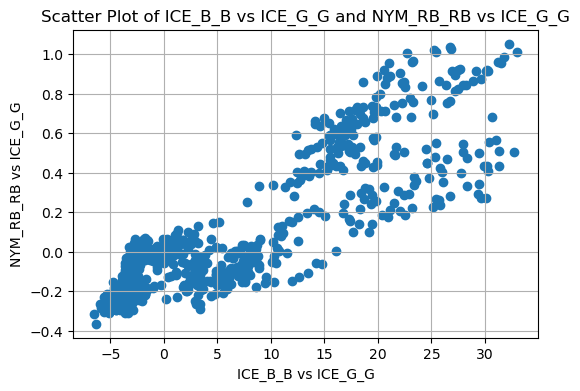

In [137]:
plt.figure(figsize=(6, 4))
plt.scatter(data_pairs['ICE_B_B vs ICE_G_G'], data_pairs['NYM_RB_RB vs ICE_G_G'])
plt.title('Scatter Plot of ICE_B_B vs ICE_G_G and NYM_RB_RB vs ICE_G_G')
plt.xlabel('ICE_B_B vs ICE_G_G')
plt.ylabel('NYM_RB_RB vs ICE_G_G')
plt.grid(True)
plt.show()

### 3.3 Time Series Analysis

#### rolling statistics 

ICE_B_B vs ICE_G_G (Left Graphs):

The rolling averages are calculated over 5, 20, 120, and 252 days.
The shorter rolling averages (5 and 20 days) show more volatility, as expected, because they react more quickly to daily fluctuations in the data.
The longer rolling averages (120 and 252 days) smooth out these fluctuations, showing the underlying trend more clearly.
There's an overall upward trend in the data as the averages increase over time, particularly noticeable with the longer averages.

NYM_RB_RB vs ICE_G_G (Right Graphs):

Similar to the left graphs, rolling averages are calculated over the same periods.
These graphs also exhibit more volatility in the short-term averages.
The trend is less clear compared to the ICE_B_B vs ICE_G_G pair, but there seems to be a slight downward trend, especially in the longer averages.

ICE_B_B vs ICE_G_G (summary statistics):

The mean values increase with longer rolling periods, suggesting that over time, there may be an overall increase in the values of ICE_B_B vs ICE_G_G. The standard deviation decreases as the rolling period increases, indicating less volatility in the long-term trends. Skewness is positive for all rolling periods, implying a long tail to the right. However, the skewness decreases with the longer rolling periods, which means that the distribution becomes more symmetrical over time. Excess kurtosis is close to zero for shorter periods but negative for longer periods, suggesting that the distribution has platykurtic distribution as the rolling period increases.

NYM_RB_RB vs ICE_G_G (summary statistics):

Mean values are quite low, close to 0, and don't show a clear trend across different rolling periods. Standard deviation is consistent across the rolling periods, indicating a stable volatility irrespective of the time frame considered. The skewness fluctuates from positive to negative as the rolling period increases. A positive skewness for the 5-day rolling average suggests a longer right tail, while the negative skewness for the 252-day rolling average suggests a longer left tail. Excess kurtosis for all periods is negative, more so for the longer rolling periods, indicating that the distribution is generally platykurtic with lighter tails.

In [249]:
# trading days: 1 wk, 1 month, 6 month, 1 year 
N = [5, 20, 120, 252]
temp_list_1 = list()
temp_list_2 = list()
for i in N: 
    df_1 = rolling_diff_average(pair1, i)
    df_2 = rolling_diff_average(pair2, i)
    temp_list_1.append(df_1)
    temp_list_2.append(df_2)
rolling_pair1 = pd.concat(temp_list_1, axis = 1)
rolling_pair2 = pd.concat(temp_list_2, axis = 1)

In [264]:
fig = make_subplots(rows=4, cols=2, subplot_titles=('ICE_B_B vs ICE_G_G rolling 5 days', 'NYM_RB_RB vs ICE_G_G rolling 5 days','ICE_B_B vs ICE_G_G rolling 20 days', 'NYM_RB_RB vs ICE_G_G rolling 20 days', 'ICE_B_B vs ICE_G_G rolling 120 days',  'NYM_RB_RB vs ICE_G_G rolling 120 days', 'ICE_B_B vs ICE_G_G rolling 252 days', 'NYM_RB_RB vs ICE_G_G rolling 252 days'))

for i in range(4):
    fig.add_trace(
        go.Scatter(x=rolling_pair1.index, y=rolling_pair1[rolling_pair1.columns[i]], mode='lines', name=rolling_pair1.columns[i]),
        row=i+1, col=1
    )
    fig.update_xaxes(title_text='Date', row=i+1, col=1)
    fig.update_yaxes(title_text='Price', row=i+1, col=1)
for i in range(4):
    fig.add_trace(
        go.Scatter(x=rolling_pair2.index, y=rolling_pair2[rolling_pair2.columns[i]], mode='lines', name=rolling_pair2.columns[i]),
        row=i+1, col=2
    )
    fig.update_xaxes(title_text='Date', row=i+1, col=2)
    fig.update_yaxes(title_text='Price', row=i+1, col=2)
fig.show()

In [254]:
per_roll_1 = summary_statistics(rolling_pair1)
print('Rolling average summary statistics for pair 1 (ICE_B_B vs ICE_G_G):')
display(per_roll_1)
per_roll_2 = summary_statistics(rolling_pair2)
print('Rolling average summary statistics for pair 2 (ICE_G_G vs NYM_RB_RB):')
display(per_roll_2)

Rolling average summary statistics for pair 1 (ICE_B_B vs ICE_G_G):


,Mean,Standard deviation,VaR (0.05),Quantile 0.25,Median,Quantile 0.75,Skewness,Excess Kurtosis,Min,Max
Rolling_Avg_5,6.867,10.515,-4.324,-2.787,3.168,16.329,0.678,-0.871,-5.681,31.103
Rolling_Avg_20,6.891,10.290,-4.279,-2.884,2.843,16.547,0.584,-1.085,-5.184,28.837
Rolling_Avg_120,7.657,9.555,-3.938,-1.716,6.481,17.563,0.260,-1.437,-3.995,23.621
Rolling_Avg_252,8.905,7.788,-2.770,0.729,11.591,16.007,-0.325,-1.472,-2.876,18.761


Rolling average summary statistics for pair 2 (ICE_G_G vs NYM_RB_RB):


,Mean,Standard deviation,VaR (0.05),Quantile 0.25,Median,Quantile 0.75,Skewness,Excess Kurtosis,Min,Max
Rolling_Avg_5,0.105,0.339,-0.259,-0.143,-0.008,0.341,1.001,-0.112,-0.310,0.992
Rolling_Avg_20,0.102,0.332,-0.258,-0.133,0.003,0.304,1.010,-0.139,-0.293,0.900
Rolling_Avg_120,0.129,0.296,-0.231,-0.087,0.010,0.371,0.709,-0.811,-0.243,0.717
Rolling_Avg_252,0.176,0.214,-0.129,-0.043,0.246,0.382,-0.224,-1.569,-0.132,0.450


#### Augmented Dickey-Fuller test

The p-values for both pairs are above 0.05, indicating that we fail to reject the null hypothesis for both spreads. This suggests that there is not enough statistical evidence to conclude that either spread is stationary. It is not very surprising since those are financial data. 

In [255]:
adf_test_pair1 = adfuller(pair1)
print('ADF Statistic for Pair 1:', adf_test_pair1[0])
print('p-value for Pair 1:', adf_test_pair1[1])

ADF Statistic for Pair 1: -2.0653748829334018
p-value for Pair 1: 0.2586634497428085


In [256]:
adf_test_pair2 = adfuller(pair2)
print('ADF Statistic for Pair 2:', adf_test_pair2[0])
print('p-value for Pair 2:', adf_test_pair2[1])

ADF Statistic for Pair 2: -2.04115539326138
p-value for Pair 2: 0.2688243722330436


#### Autocorrelation and partial autocorrelation plots

Both pairs show signs of an AR(1) process, but Pair 1's ACF's slow decay suggests non-stationarity, and Pair 2's ACF indicates a possible seasonal or mixed AR/MA process.

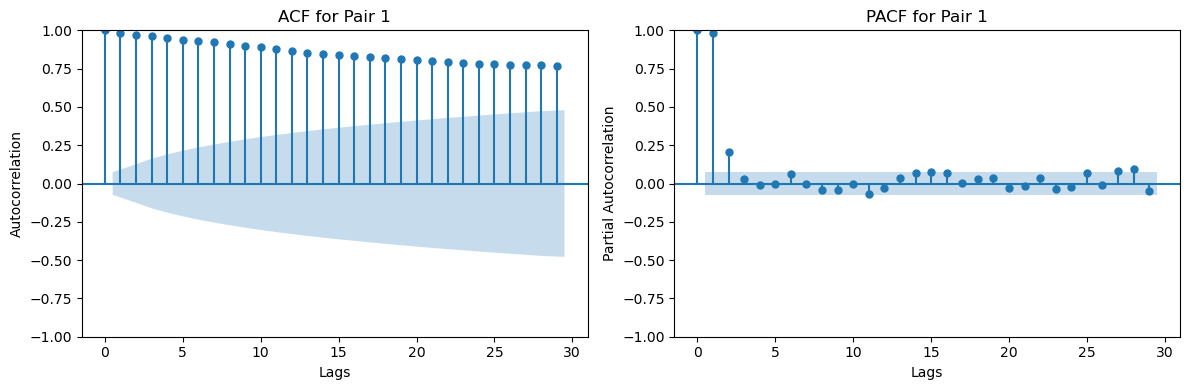

In [271]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
plot_acf(pair1, ax=axes[0])
axes[0].set_title('ACF for Pair 1') 
axes[0].set_xlabel('Lags')  
axes[0].set_ylabel('Autocorrelation')
plot_pacf(pair1, ax=axes[1], method ='ywm')
axes[1].set_title('PACF for Pair 1') 
axes[1].set_xlabel('Lags')  
axes[1].set_ylabel('Partial Autocorrelation')  

plt.tight_layout()
plt.show()

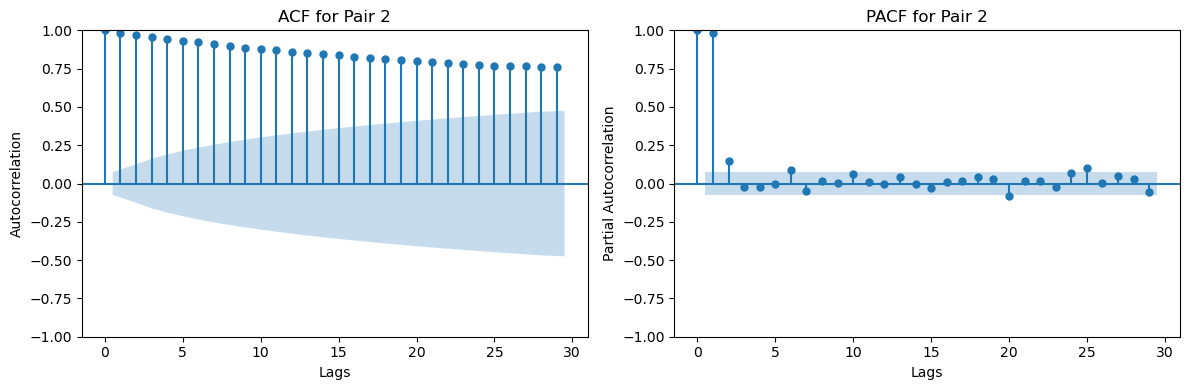

In [272]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
plot_acf(pair2, ax=axes[0])
axes[0].set_title('ACF for Pair 2') 
axes[0].set_xlabel('Lags')  
axes[0].set_ylabel('Autocorrelation')
plot_pacf(pair2, ax=axes[1], method ='ywm')
axes[1].set_title('PACF for Pair 2') 
axes[1].set_xlabel('Lags')  
axes[1].set_ylabel('Partial Autocorrelation')  

plt.tight_layout()
plt.show()

### 3.4 Comparative Analysis

#### Correlation between two spreads 

It shows that those two pairs have a high correlation. Since both of them incoporated ICE_G_G, its not surprising. Besides that, the Brent gas oil and gasoline may also have some level of assocaition. 

In [259]:
data_pairs.corr()

,ICE_B_B vs ICE_G_G,NYM_RB_RB vs ICE_G_G
ICE_B_B vs ICE_G_G,1.000000,0.859656
NYM_RB_RB vs ICE_G_G,0.859656,1.000000


#### Dynamic Corrleation between two spreads 

The rolling averages with shorter time frames (5 and 20 days) have higher correlations with each other, indicating that they move together more closely in the short term. As the rolling period increases, the correlation generally decreases. However, there are some high correlations between longer rolling averages, like the 120-day average for ICEBB_ICEGG and the 252-day average for NYMRBB_ICEGG, which suggests a consistent relationship over a longer period. The lowest correlation is observed between the 5-day average for NYMRBB_ICEGG and the 252-day average for ICEBB_ICEGG, suggesting that short-term fluctuations in pair of futures do not relate well with long-term trends in the other.

In [260]:
rolling_pairs = rolling_pair1.join(rolling_pair2, lsuffix='_ICEBB_ICEGG', rsuffix='_NYMRBRB_ICEGG')
cor_roll = rolling_pairs.corr()
cor_roll = cor_roll.iloc[4:,:-4]
cor_roll

,Rolling_Avg_5_ICEBB_ICEGG,Rolling_Avg_20_ICEBB_ICEGG,Rolling_Avg_120_ICEBB_ICEGG,Rolling_Avg_252_ICEBB_ICEGG
Rolling_Avg_5_NYMRBRB_ICEGG,0.863003,0.855026,0.698788,0.127944
Rolling_Avg_20_NYMRBRB_ICEGG,0.829917,0.873664,0.768001,0.186607
Rolling_Avg_120_NYMRBRB_ICEGG,0.616419,0.693751,0.941172,0.645946
Rolling_Avg_252_NYMRBRB_ICEGG,0.148003,0.228997,0.737837,0.996985


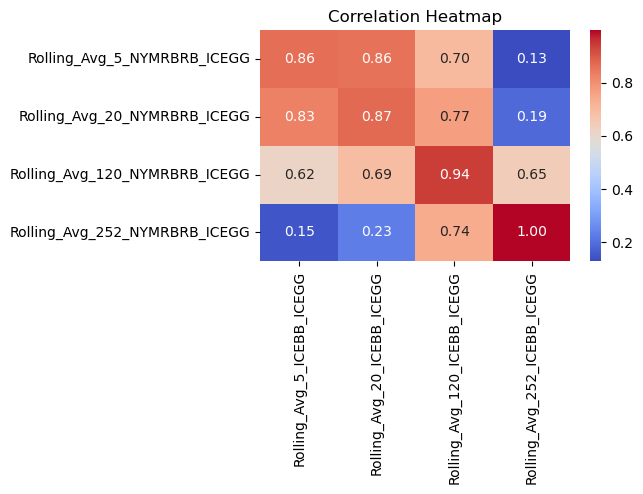

In [261]:
plt.figure(figsize=(5, 3))   
sns.heatmap(cor_roll, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

#### Cointegration test

The p-value is approximately 0.089, which is above the common threshold of 0.05, suggesting that there isn't strong evidence to reject the null hypothesis of no cointegration.

In [262]:
score, p_value, _ = coint(data_pairs['ICE_B_B vs ICE_G_G'], data_pairs['NYM_RB_RB vs ICE_G_G'])
print(f"Cointegration test score: {score}")
print(f"P-value: {p_value}")

Cointegration test score: -3.096706202578152
P-value: 0.08896627685513026


#### difference between two spreads 

Here are some basic analysis for the difference between two pairs, since these two spreads have very large value difference, it is not surprised to see that majority of the time, the first pair is larger than the second pair. 

In [274]:
diff = pair1 - pair2 
performance_summary(diff)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max
FuturePrice,80.954638,35.747064,2.264651,0.712173,-0.744135,-4.1867,-4.896726,-6.19605,32.1682


In [279]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Scatter(x=diff.index, y=diff['FuturePrice'], mode='lines', name='ICE_B_B vs ICE_G_G - NYM_RB_RB vs ICE_G_G'),
    row=1, col=1
)

fig.update_xaxes(title_text='Date', row=1, col=1)  
fig.update_yaxes(title_text='Price', row=1, col=1)  

fig.show()

## 4. Conclusion 

From the correlation analysis, it is evident that the two pairs exhibit a strong positive relationship, which is expected given their shared commodity, indicating an inherent market association. The year 2022, in particular, shows a distinct upward trend in the prices of oil and gasoline, a pattern that can be reasonably attributed to the market disruptions caused by the Russia-Ukraine conflict. This geopolitical event has not only introduced a pronounced trend but also contributed to heightened volatility in price differences, reflecting the market's sensitivity to supply and demand shocks.

By employing rolling average analysis, we observe that despite short-term fluctuations, these sudden changes do not significantly alter the long-term trend (in long term, it shows a gradual increase rather than the sudden hike). This finding suggests a certain resilience or mean-reverting behavior in the market. However, to gain deeper insights, further analysis could be conducted by isolating the period impacted by the conflict, which would allow for a clearer understanding of intrinsic market dynamics outside of these extraordinary circumstances. Conversely, a focused study on the period of the conflict could shed light on the extent and nature of the market's response to such geopolitical tensions.

## 5. Reference 
Data Fetching: 
https://data.nasdaq.com/data/OWF-optionworks-futures-options/documentation 


Chatgpt Prompt Used: basic tools for exploratory data analysis of time series data 

Oil Price trend:
https://www.eia.gov/todayinenergy/detail.php?id=55079#:~:text=The%20Brent%20crude%20oil%20spot,to%20crude%20oil%20price%20increases.

https://www.iea.org/reports/oil-market-report-august-2023

